In [46]:
import numpy as np
import cv2
import time
import pandas as pd 
from scipy.stats import pearsonr
from matplotlib import pyplot as plt 
import seaborn as sns 

In [2]:
RESIZE_RATIO = 1
STEP_FRAME = 1

In [3]:
cap = cv2.VideoCapture("../videos/Videos1.avi")

suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
h, w = list(prevgray.shape[:2])[::-1]
prevgray = cv2.resize(prevgray,( h // RESIZE_RATIO, w // RESIZE_RATIO))
prevgray = prevgray.T

In [4]:
flow_list = []
count = 0
speeds = None

while True:
    count += 1

    suc, img = cap.read()
    if (suc ):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (h // RESIZE_RATIO, w // RESIZE_RATIO))
        # start time to calculate FPS
        gray = gray.T
        start = time.time()


        flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow = np.expand_dims(flow, axis=0)
        if count == 1:
            speeds = flow
        else:
            speeds = np.concatenate((speeds, flow), axis=0)
    if(count > 162):
        break
    

(163, 960, 544, 2)

In [6]:
cap.release()

0, 1, 2
3, 4, 5
6, 7, 8

In [30]:
def plot_speeds_group(speeds, group = 3, show_figure = 1):
    start_id = group // 2
    half_frame = group // 2
    result = None
    for i in range(show_figure):
        total_speed = np.zeros(shape=speeds.shape[1:])
        for j in range(start_id - half_frame, start_id + half_frame):
            total_speed = total_speed + speeds[j]
            
        avg_speed = np.expand_dims(total_speed / group, axis = 0)
        start_id = start_id + group
        if i == 0:
            result = avg_speed
        else:
            result = np.concatenate((result, avg_speed))
    return result

In [43]:
window = 3
mean_speed = np.concatenate([np.expand_dims(speeds[i : i + window].mean(axis = 0),axis = 0) for i in range(0, speeds.shape[0], window)]) 

In [45]:
mean_speed.shape

(55, 960, 544, 2)

In [33]:
y_ind = 120
plt.plot(mean_speed[0])

array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]]])

In [47]:
from utils.flow import frames_to_bgrs, calc_flow_index

In [48]:
bgr = frames_to_bgrs(mean_speed)

In [49]:
bgr.shape

(55, 960, 544, 3)

In [50]:
real_point = np.array("2.134	   2.868	2.638	2.82	3.396	3.063	2.907	2.362".split("\t"), dtype="float")

In [51]:
real_point

array([2.134, 2.868, 2.638, 2.82 , 3.396, 3.063, 2.907, 2.362])

In [25]:
speeds.shape 

(8, 960, 544, 2)

In [52]:
v = np.sqrt(mean_speed[..., 0] ** 2 + mean_speed[..., 1] ** 2)

In [53]:
dic = {
    "frame" : [], 
    "y_ind" : [], 
    "pearsonr" : []
}
for frame in range(8):
    for y_ind in range(0, 540, 10):
        # print(y_ind)
        map_indices = calc_flow_index(bgr, frame_index=frame, y_ind=y_ind)
        pred = v[frame][y_ind, map_indices]
        # lr = LinearRegression(fit_intercept=True)

        corr, p = pearsonr(real_point, pred)
        dic["frame"].append(frame)
        dic["y_ind"].append(y_ind)
        dic["pearsonr"].append(corr)
    print(frame)

0
1
2
3
4
5
6
7


In [54]:
result = pd.DataFrame(dic)

In [55]:
result.head()

,frame,y_ind,pearsonr
0,0,0,0.283471
1,0,10,0.261629
2,0,20,-0.316791
3,0,30,0.256179
4,0,40,0.303833


In [56]:
result = result.sort_values(by = "pearsonr", ascending=False)

In [65]:
result.head()

,frame,y_ind,pearsonr
182,3,200,0.915410
127,2,190,0.822455
146,2,380,0.764886
200,3,380,0.735896
178,3,160,0.729653


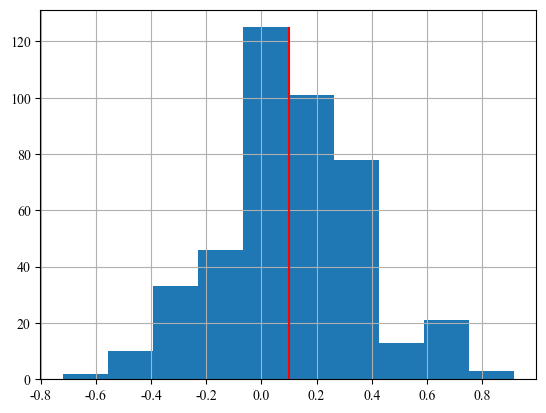

In [68]:
result["pearsonr"].hist()
plt.vlines(x = result["pearsonr"].mean(), ymin=0, ymax=125, color = "red")

<Axes: >

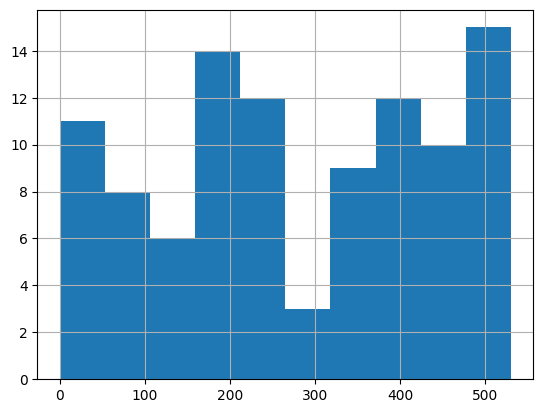

In [57]:
result.head(100)["y_ind"].hist()

In [58]:
frame, y_ind = result.iloc[0, :][["frame", "y_ind"]].values.astype("int").tolist()

In [59]:
indicies = calc_flow_index(bgr, frame_index=frame, y_ind=y_ind)

In [60]:
pred = v[frame][y_ind, indicies]

In [61]:
pred

array([3.6413127e-05, 8.0292270e-02, 1.5447534e-02, 8.6343005e-02,
       2.0897061e-01, 1.4143132e-01, 5.7794459e-02, 2.4958758e-02],
      dtype=float32)

In [62]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(pred.reshape(-1, 1), real_point)

LinearRegression()

In [63]:
validate_speed = pred * lr.coef_ + lr.intercept_
validate_speed

array([2.3764517, 2.7909732, 2.4560502, 2.822225 , 3.4555964, 3.1067562,
       2.6747718, 2.5051756], dtype=float32)

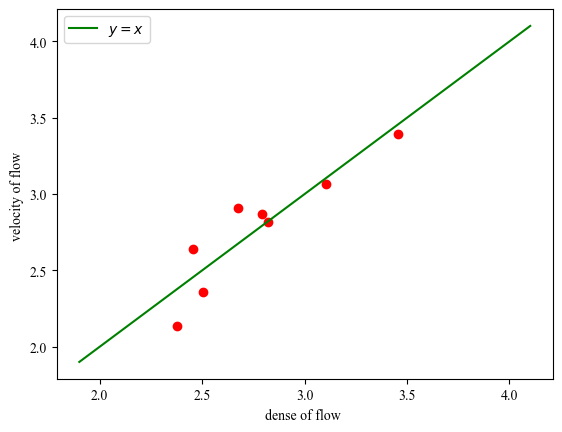

In [64]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
step = np.arange(validate_speed.min() * 0.8 , validate_speed.max() * 1.2, 0.1)
plt.scatter(validate_speed, real_point, color = "red")
plt.plot(step, step , label = "$y = x$", color = "green")
plt.xlabel("dense of flow ")
plt.ylabel("velocity of flow ")
plt.legend()